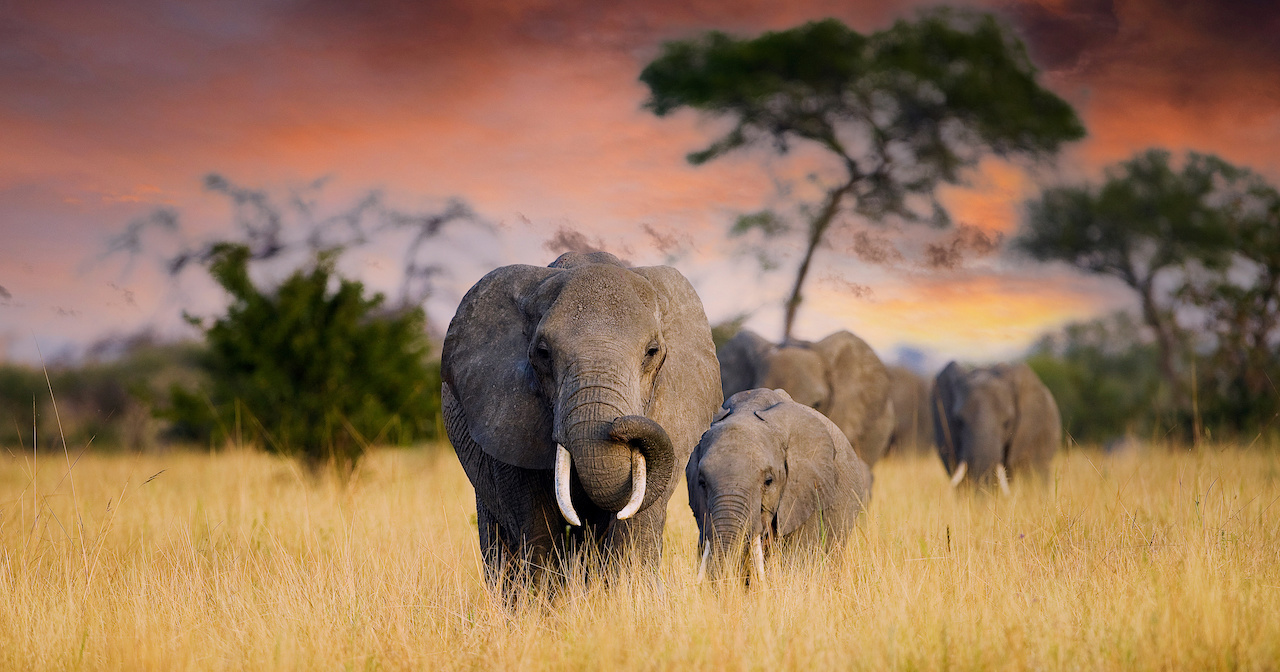
Photo by <a href="https://stock.adobe.com/contributor/19000/mat-hayward?load_type=author&prev_url=detail" >Mat Hayward</a> on Adobe Stock

# Phase 4 Project: *The Met Museum Ivory Art Classification Model*

### By Ryan Posternak and Harrison Carter

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 6th, 2022<br>
Instructor: Joseph Mata

## Goal: Identify whether a piece of artwork among the Met museum's art collection is made of ivory or not

<br>

# Overview and Business Understanding

<br>

Each year, poachers kill an estimated 20,000 [WWF] wild elephants for illegal trade, mostly dealing in ivory. With only 495,000 elephants left in the wild across Asia and Africa, this leaves precious few years for these animals on the planet. In 2016, many countries including the United States, United Kingdom, Singapore and others implemented a near complete ban on importing and sales of ivory and ivory products. In a massive step, China followed suit the following year, disallowing legal sale of ivory within the country. Unfortunately this is not enough, as consumer imports of ivory from abroad are still allowed. In places like Vietnam and Thailand, the sale of ivory is illegal in name only, with little to no enforcement and street vendors and jewelry shops alike populating their shelves brazenly. This lieads to a wholly unregulated market, with 
To combat this, wildlife conservationists are constantly urging countries worldwide to enact stricter legislation

# Data Understanding

<br>

# Sourcing the Data

### Import libraries, packages and modules

In [1]:
import numpy as np
import pandas as pd
import requests
import time
import random
from PIL import Image
from io import BytesIO
import os
import shutil

### Connect to Met API

In [2]:
# API URL to obtain IDs of ivory objects
ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ivory&q=*'

# API URL to obtain IDs of (expected to be) non-ivory ceramic objects
non_ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ceramics&hasImages=true&q=*'

# Ivory objects request
ivory_r = requests.get(ivory_url)

# Non-ivory objects request
non_ivory_r = requests.get(non_ivory_url)

ivory_r.status_code, non_ivory_r.status_code

(200, 200)

In [3]:
# Retrieve objectIds
ivory_objectIDs = ivory_r.json()['objectIDs']
non_ivory_objectIDs = non_ivory_r.json()['objectIDs']


print(f"Number of ivory objects: {len(ivory_objectIDs)}")
print(f"Number of ceramic objects: {len(non_ivory_objectIDs)}")

Number of ivory objects: 5975
Number of ceramic objects: 25603


In [4]:
# Let's view the full data on one museum art piece (the first ivory object in our list)
url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

requests.get(url + str(ivory_objectIDs[0])).json()

{'objectID': 248694,
 'isHighlight': False,
 'accessionNumber': '12.229.23b',
 'accessionYear': '1912',
 'isPublicDomain': True,
 'primaryImage': 'https://images.metmuseum.org/CRDImages/gr/original/sf1222923b.jpg',
 'primaryImageSmall': 'https://images.metmuseum.org/CRDImages/gr/web-large/sf1222923b.jpg',
 'additionalImages': [],
 'constituents': None,
 'department': 'Greek and Roman Art',
 'objectName': 'Relief of a duck',
 'title': 'Relief of a duck',
 'culture': 'Roman',
 'period': 'Early Imperial',
 'dynasty': '',
 'reign': '',
 'portfolio': '',
 'artistRole': '',
 'artistPrefix': '',
 'artistDisplayName': '',
 'artistDisplayBio': '',
 'artistSuffix': '',
 'artistAlphaSort': '',
 'artistNationality': '',
 'artistBeginDate': '',
 'artistEndDate': '',
 'artistGender': '',
 'artistWikidata_URL': '',
 'artistULAN_URL': '',
 'objectDate': '1st century A.D.',
 'objectBeginDate': 1,
 'objectEndDate': 99,
 'medium': 'Bone',
 'dimensions': '1 13/16 × 5/8 × 4 3/16 in. (4.7 × 1.6 × 10.6 cm)',

### Create container lists with selected attributes

In [7]:
# Initialize lists
ivory_primaryImageSmall_urls = []
ivory_titles = []
ivory_objectNames = []
ivory_mediums = []
ivory_classifications = []
ivory_departments = []
ivory_cultures = []
ivory_periods = []
ivory_objectDates = []

# Compile containers
attribute_containers = [ivory_primaryImageSmall_urls, ivory_titles, ivory_objectNames, ivory_mediums, 
                        ivory_classifications, ivory_departments, ivory_cultures, ivory_periods, ivory_objectDates]

# Compile key names of attributes
attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
              'classification', 'department', 'culture', 'period', 'objectDate']

# Execute API requests
objects_url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'
if os.path.isfile('data/final_df.csv') == False:  # Prevent running duplicate API requests
    for objectID in ivory_objectIDs:
        r = requests.get(objects_url + str(objectID))
        for attribute_container, attribute in zip(attribute_containers, attributes):
            try:
                attribute_container.append(r.json()[attribute])
            except:
                attribute_container.append(np.nan)  # Some keys are missing on select objects
        time.sleep(1/160)  # Throttle API request rate to conform with API documentation

### Create dataframe of ivory art pieces

In [8]:
ivory_df = pd.DataFrame(ivory_objectIDs, columns=['Object_ID'])

ivory_df['Image_URL'] = ivory_primaryImageSmall_urls
ivory_df['Title'] = ivory_titles
ivory_df['Object_Name'] = ivory_objectNames
ivory_df['Medium'] = ivory_mediums
ivory_df['Classification'] = ivory_classifications
ivory_df['Department'] = ivory_departments
ivory_df['Culture'] = ivory_cultures
ivory_df['Period'] = ivory_periods
ivory_df['Object_Date'] = ivory_objectDates

# Ivory art pieces will have class labels of 1
ivory_df['Target'] = 1

ivory_df.replace(to_replace='', value=np.nan, inplace=True)

print(ivory_df.shape)
ivory_df.head()

ValueError: Length of values (0) does not match length of index (5975)

In [ ]:
# How many of the ivory objects have valid (small) image URLs?
num_ivory_objects_with_image = ivory_df.shape[0] - ivory_df.Image_URL.isna().sum()
num_ivory_objects_with_image

In [ ]:
# Choose 5,975 random objectIds from the non_ivory_objectIDs list
np.random.seed(10)
selected_non_ivory_objectIDs = np.random.choice(non_ivory_objectIDs, size=5975, replace=False)
len(selected_non_ivory_objectIDs)

### Repeat steps above to create dataframe of non-ivory art pieces

In [ ]:
non_ivory_primaryImageSmall_urls = []
non_ivory_titles = []
non_ivory_objectNames = []
non_ivory_mediums = []
non_ivory_classifications = []
non_ivory_departments = []
non_ivory_cultures = []
non_ivory_periods = []
non_ivory_objectDates = []

attribute_containers = [non_ivory_primaryImageSmall_urls, non_ivory_titles, non_ivory_objectNames, 
                        non_ivory_mediums, non_ivory_classifications, non_ivory_departments, non_ivory_cultures, 
                        non_ivory_periods, non_ivory_objectDates]

attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
              'classification', 'department', 'culture', 'period', 'objectDate']


objects_url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

if os.path.isfile('data/final_df.csv') == False:  # Prevent running duplicate API requests
    for objectID in selected_non_ivory_objectIDs:
        r = requests.get(objects_url + str(objectID))
        for attribute_container, attribute in zip(attribute_containers, attributes):
            try:
                attribute_container.append(r.json()[attribute])
            except:
                attribute_container.append(np.nan)
        time.sleep(1/160)

In [ ]:
non_ivory_df = pd.DataFrame(selected_non_ivory_objectIDs, columns=['Object_ID'])

non_ivory_df['Image_URL'] = non_ivory_primaryImageSmall_urls
non_ivory_df['Title'] = non_ivory_titles
non_ivory_df['Object_Name'] = non_ivory_objectNames
non_ivory_df['Medium'] = non_ivory_mediums
non_ivory_df['Classification'] = non_ivory_classifications
non_ivory_df['Department'] = non_ivory_departments
non_ivory_df['Culture'] = non_ivory_cultures
non_ivory_df['Period'] = non_ivory_periods
non_ivory_df['Object_Date'] = non_ivory_objectDates

# Non-ivory art pieces will have class labels of 0
non_ivory_df['Target'] = 0

# Remove objects without valid (small) image URLs
non_ivory_df.replace(to_replace='', value=np.nan, inplace=True)
non_ivory_df.dropna(subset=['Image_URL'], inplace=True)

print(non_ivory_df.shape)
non_ivory_df.head()

### Concatenate dataframes

In [ ]:
merged_df = pd.concat([ivory_df, non_ivory_df], ignore_index=True)
print(merged_df.shape)
merged_df.head()

# Data Preprocessing

### Drop duplicate object IDs, null image URLs, and duplicate image URLs

In [ ]:
print('Before preprocessing:' + '\n')

# Search for duplicate Object_IDs
num_dup_IDs = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]
print(str(num_dup_IDs) + ' duplicate Object_IDs')

# Remove from dataframe (keep first occurrence)
dup_ID_indexes = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].index
merged_df = merged_df.drop(dup_ID_indexes)

# Search for NaN Image_URLs
num_NaN_Image_URLs = merged_df.loc[merged_df['Image_URL'].isna()].shape[0]
print(str(num_NaN_Image_URLs) + ' null Image_URLs')

# Remove from dataframe
NaN_Image_URL_indexes = merged_df.loc[merged_df['Image_URL'].isna()].index
merged_df = merged_df.drop(NaN_Image_URL_indexes)

# Search for duplicate Image_URLs
num_dup_Image_URLs = merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]
print(str(num_dup_Image_URLs) + ' duplicate Image_URLs')

# Remove from dataframe (keep first occurrence)
dup_Image_URL_indexes = merged_df.loc[merged_df.duplicated(subset='Image_URL')].index
merged_df = merged_df.drop(dup_Image_URL_indexes)

print('-'*30)
print('After preprocessing:' + '\n')
print(str(merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]) + ' duplicate Object_IDs')
print(str(merged_df.loc[merged_df['Image_URL'].isna()].shape[0]) + ' null Image_URLs')
print(str(merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]) + ' duplicate Image_URLs')

In [ ]:
# Let's preview the mediums of our ivory objects
merged_df.loc[merged_df.Target == 1].Medium.value_counts()[:30]

In [ ]:
# These are the art mediums that appear most relevant to our search for ivory objects. The others might hardly 
# have any trace of bone/ivory for the model to pick up on
ivory_indexes_to_keep = merged_df.loc[(merged_df.Medium == 'Ivory') | 
                                      (merged_df.Medium == 'Bone') | 
                                      (merged_df.Medium == 'Bone, ivory') | 
                                      (merged_df.Medium == 'Elephant ivory') | 
                                      (merged_df.Medium == 'Bone; carved') | 
                                      (merged_df.Medium == 'Ivory (walrus)') | 
                                      (merged_df.Medium == 'ivory') | 
                                      (merged_df.Medium == 'Walrus ivory') | 
                                      (merged_df.Medium == 'Bone; incised') | 
                                      (merged_df.Medium == 'Ivory with metal mounts') | 
                                      (merged_df.Medium == 'Ivory or bone') | 
                                      (merged_df.Medium == 'Ivory (elephant)')
                                     ].index

# Let's preview three items from above
np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

In [ ]:
# Just to be sure, let's preview three items that don't fit the medium descriptions above, to see if they are 
# still recognizable as ivory or not
all_ivory_indexes = merged_df.loc[merged_df.Target == 1].index
ivory_indexes_to_drop = [index for index in all_ivory_indexes if index not in ivory_indexes_to_keep]

np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_drop, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

**Remarks**:
- As suspected, the images not among the selected mediums appear to have little, if any, traces of ivory, although ivory may be some element of their composition. We'll go ahead and keep only the items among the selected mediums. Even though this will be costly in terms of lost data, these art pieces we're dropping would likely bring more noise than signal.

In [ ]:
new_ivory_df = merged_df.loc[ivory_indexes_to_keep]
print(new_ivory_df.shape)
new_ivory_df.head()

In [ ]:
# To maintain a balanced dataset, let's now select 1,770 (random) art pieces from among the non-ivory items

np.random.seed(42)
non_ivory_indexes_to_keep = np.random.choice(merged_df.loc[merged_df['Target'] == 0].index, 
                                             size=1770, 
                                             replace=False)

new_non_ivory_df = merged_df.loc[non_ivory_indexes_to_keep]
print(new_non_ivory_df.shape)
new_non_ivory_df.head()

In [ ]:
# Let's preview what some non-ivory art pieces look like, to compare
np.random.seed(45)
for index in np.random.choice(non_ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

### Concatenate new dataframes

In [ ]:
final_df = pd.concat([new_ivory_df, new_non_ivory_df], ignore_index=True)
print(final_df.shape)
final_df.head()

### Save images to data folder

In [ ]:
ivory_indexes = final_df.loc[final_df['Target'] == 1].index
non_ivory_indexes = final_df.loc[final_df['Target'] == 0].index

# Sanity check
ivory_indexes.shape[0] + non_ivory_indexes.shape[0] == final_df.shape[0]

In [ ]:
ivory_dir_len = len([name for name in os.listdir('data/images/ivory') if not name.endswith('checkpoints')])

unidentified_ivory_images = []

if ivory_dir_len == 0:
    for index in ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/ivory/ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_ivory_images.append(index)
        
unidentified_ivory_images

In [ ]:
non_ivory_dir_len = len([name for name in os.listdir('data/images/non_ivory') if not name.endswith('checkpoints')])

unidentified_non_ivory_images = []

if non_ivory_dir_len == 0:
    for index in non_ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/non_ivory/non_ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_non_ivory_images.append(index)
            
unidentified_non_ivory_images

### Drop rows with invalid image URLs

In [ ]:
final_df = final_df.drop(unidentified_ivory_images)
final_df = final_df.drop(unidentified_non_ivory_images)

# Reset indexes
final_df.index = range(len(final_df))

final_df.Target.value_counts()

### Save dataframe as .csv file

In [ ]:
if os.path.isfile('data/final_df.csv') == False:
    final_df.to_csv('data/final_df.csv')
else:
    final_df = pd.read_csv('data/final_df.csv', index_col=0)

### Create train, validation, and test splits of ivory and non-ivory images

In [ ]:
data_ivory_dir = 'data/images/ivory/'
data_non_ivory_dir = 'data/images/non_ivory/'
split_dir = 'data/split/'

test_ivory = 'data/split/test/ivory/'
test_non_ivory = 'data/split/test/non_ivory/'

validation_ivory = 'data/split/validation/ivory/'
validation_non_ivory = 'data/split/validation/non_ivory/'

train_ivory = 'data/split/train/ivory/'
train_non_ivory = 'data/split/train/non_ivory/'

In [ ]:
imgs_ivory = [file for file in os.listdir(data_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_ivory)

print('There are', len(imgs_ivory), 'ivory images')
imgs_ivory[:3]

In [ ]:
imgs_non_ivory = [file for file in os.listdir(data_non_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_non_ivory)

print('There are', len(imgs_non_ivory), 'non-ivory images')
imgs_non_ivory[:3]

In [ ]:
# We'll do an 80/20 train/test split; of the training data, we'll do another 80/20 train/validation split

print(f"Ivory test images slice:        {int(1769*0.8)+1}:1769  --> {int(1769*0.2)} images")
print(f"Ivory validation images slice:  {int(1415*0.8)+1}:{int(1769*0.8)+1}  --> {int(1415*0.2)} images")
print(f"Ivory train images slice:       0:{int(1415*0.8)+1}     --> {int(1415*0.8)+1} images")

In [ ]:
# Repeat for non-ivory images

print(f"Non-ivory test images slice:        {int(1767*0.8)+1}:1767  --> {int(1767*0.2)} images")
print(f"Non-ivory validation images slice:  {int(1414*0.8)+1}:{int(1767*0.8)+1}  --> {int(1414*0.2)} images")
print(f"Non-ivory train images slice:       0:{int(1414*0.8)+1}     --> {int(1414*0.8)+1} images")

In [ ]:
# Test ivory images
imgs = imgs_ivory[1416:1769]
dir_length = len([name for name in os.listdir('data/split/test/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(test_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation ivory images
imgs = imgs_ivory[1133:1416]
dir_length = len([name for name in os.listdir('data/split/validation/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(validation_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train ivory images
imgs = imgs_ivory[0:1133]
dir_length = len([name for name in os.listdir('data/split/train/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(train_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_ivory)), 'ivory images in the test set')
print('There are', len(os.listdir(validation_ivory)), 'ivory images in the validation set')
print('There are', len(os.listdir(train_ivory)), 'ivory images in the train set')

In [ ]:
# Test non-ivory images
imgs = imgs_non_ivory[1414:1767]
dir_length = len([name for name in os.listdir('data/split/test/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(test_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation non-ivory images
imgs = imgs_non_ivory[1132:1414]
dir_length = len([name for name in os.listdir('data/split/validation/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(validation_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train non-ivory images
imgs = imgs_non_ivory[0:1132]
dir_length = len([name for name in os.listdir('data/split/train/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(train_non_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_non_ivory)), 'non-ivory images in the test set')
print('There are', len(os.listdir(validation_non_ivory)), 'non-ivory images in the validation set')
print('There are', len(os.listdir(train_non_ivory)), 'non-ivory images in the train set')

## Further Work

- Distinguishing elephant vs mammoth vs walrus ivory - mammoth ivory is unregulated globally and elephant ivory is often passed off as elephant ivory. Walrus ivory is an important economic resource to some North American indigenous tribes.
- Using X-ray data - the refractive  
- 